##### Copyright 2020 The TensorFlow Authors.

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# 加载和预处理图像

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/load_data/images"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/images.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/images.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/load_data/images.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

## 配置

In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
print(tf.__version__)

2.11.0


### 检索图片

本教程使用一个包含数千张花卉照片的数据集。该花卉数据集包含 5 个子目录，每个子目录对应一个类：

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

注：所有图像均获得 CC-BY 许可，创作者在 LICENSE.txt 文件中列出。

In [6]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 122s 1us/step


下载 (218MB) 后，您现在应该拥有花卉照片的副本。总共有 3670 个图像：

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


每个目录都包含该类型花卉的图像。下面是一些玫瑰：

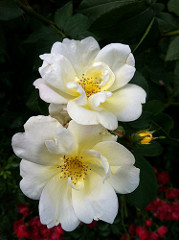

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

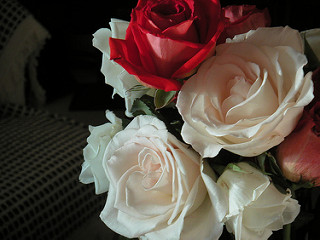

In [9]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## 使用 Keras 效用函数加载数据

让我们使用实用的 `tf.keras.utils.image_dataset_from_directory` 效用函数从磁盘加载这些图像。

### 创建数据集

为加载器定义一些参数：

In [10]:
batch_size = 32
img_height = 180
img_width = 180

开发模型时，最好使用验证拆分。您将使用 80% 的图像进行训练，20% 的图像进行验证。

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


您可以在这些数据集的 `class_names` 特性中找到类名称。

In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 呈现数据

下面是训练数据集中的前 9 个图像。

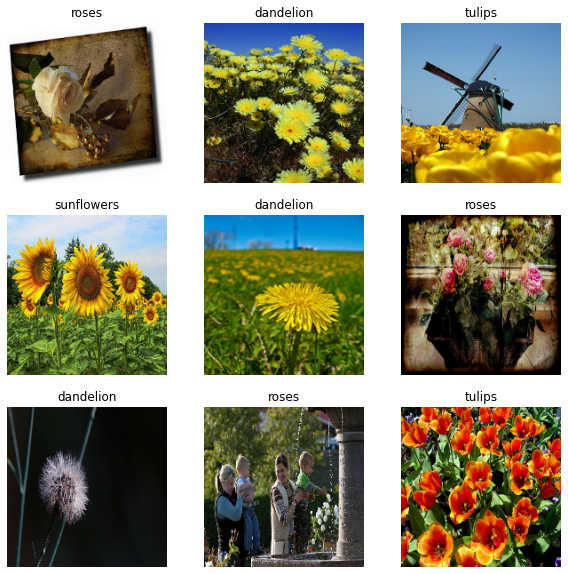

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

您可以使用这些数据集来训练模型，方法是将它们传递给 `model.fit`（在本教程后面展示）。如果愿意，您还可以手动迭代数据集并检索批量图像：

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch` 是形状为 `(32, 180, 180, 3)` 的张量。这是由 32 个形状为 `180x180x3`（最后一个维度是指颜色通道 RGB）的图像组成的批次。`label_batch` 是形状为 `(32,)` 的张量，这些是 32 个图像的对应标签。

您可以对这些张量中的任何一个调用 `.numpy()` 以将它们转换为 `numpy.ndarray`。

### 标准化数据


RGB 通道值在 `[0, 255]` 范围内。这对于神经网络来说并不理想；一般而言，您应当设法使您的输入值变小。

在这里，我们通过使用 `tf.keras.layers.Rescaling` 将值标准化为在 `[0, 1]` 范围内。

In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

可以通过两种方式使用该层。您可以通过调用 `Dataset.map` 将其应用于数据集：

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 0.96902645


或者，您也可以在模型定义中包含该层以简化部署。在这里，您将使用第二种方式。

注：如果您想将像素值缩放到 `[-1,1]`，则可以改为编写 `tf.keras.layers.Rescaling(1./127.5, offset=-1)`

注：您之前使用 `tf.keras.utils.image_dataset_from_directory` 的 `image_size` 参数调整了图像大小。如果您还希望在模型中包括调整大小的逻辑，可以使用 `tf.keras.layers.Resizing` 层。

### 配置数据集以提高性能

我们确保使用缓冲预获取，以便您可以从磁盘生成数据，而不会导致 I/O 阻塞。下面是加载数据时应当使用的两个重要方法。

- 在第一个周期期间从磁盘加载图像后，`Dataset.cache()` 会将这些图像保留在内存中。这将确保在训练模型时数据集不会成为瓶颈。如果数据集太大无法装入内存，您也可以使用此方法创建高性能的磁盘缓存。
- `Dataset.prefetch()` 会在训练时将数据预处理和模型执行重叠。

感兴趣的读者可以在<a>使用 tf.data API 提升性能</a>指南的<em>预提取</em>部分了解更多有关这两种方法的详细信息，以及如何将数据缓存到磁盘。

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 训练模型

为了完整起见，您现在将使用刚刚准备的数据集来训练一个简单模型。

[序贯](https://tensorflow.google.cn/guide/keras/sequential_model)模型由三个卷积块 (`tf.keras.layers.Conv2D`) 组成，每个卷积块都有一个最大池化层 (`tf.keras.layers.MaxPooling2D`)。有一个全连接层 (`tf.keras.layers.Dense`)，上面有 128 个单元，由 ReLU 激活函数 (`'relu'`) 激活。此模型尚未进行任何调整（目标是使用您刚刚创建的数据集展示机制）。要详细了解图像分类，请访问[图像分类](../images/classification.ipynb)教程。

In [19]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

选择 `tf.keras.optimizers.Adam` 优化器和 `tf.keras.losses.SparseCategoricalCrossentropy` 损失函数。要查看每个训练周期的训练和验证准确率，请将 `metrics` 参数传递给 `Model.compile`。

In [20]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

注：您将仅训练几个周期，因此本教程的运行速度很快。 

In [21]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 30s 314ms/step - loss: 1.3255 - accuracy: 0.4356 - val_loss: 1.1214 - val_accuracy: 0.5545
Epoch 2/3
92/92 [==============================] - 26s 284ms/step - loss: 1.0370 - accuracy: 0.5882 - val_loss: 1.0640 - val_accuracy: 0.5763
Epoch 3/3
92/92 [==============================] - 25s 266ms/step - loss: 0.8604 - accuracy: 0.6686 - val_loss: 0.9655 - val_accuracy: 0.6376


注：您也可以编写自定义训练循环而不是使用 `Model.fit`。要了解详情，请访问[从头编写训练循环](https://tensorflow.google.cn/guide/keras/writing_a_training_loop_from_scratch)教程。

您可能会注意到，与训练准确率相比，验证准确率较低，这表明我们的模型存在过拟合。您可以在此[教程](https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit)中详细了解过拟合以及如何减少过拟合。

## 使用 tf.data 进行更精细的控制

利用上面的 Keras 预处理效用函数 `tf.keras.utils.image_dataset_from_directory`，可以方便地从头创建 `tf.data.Dataset`。

要实现更精细的控制，您可以使用 <code>tf.data</code> 编写自己的输入流水线。本部分展示了如何做到这一点，从我们之前下载的 TGZ 文件中的文件路径开始。

In [22]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [23]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\hsuhau\\.keras\\datasets\\flower_photos\\tulips\\15516715153_08abc9bb20_n.jpg'
b'C:\\Users\\hsuhau\\.keras\\datasets\\flower_photos\\sunflowers\\1244774242_25a20d99a9.jpg'
b'C:\\Users\\hsuhau\\.keras\\datasets\\flower_photos\\dandelion\\3530500952_9f94fb8b9c_m.jpg'
b'C:\\Users\\hsuhau\\.keras\\datasets\\flower_photos\\daisy\\15327813273_06cdf42210.jpg'
b'C:\\Users\\hsuhau\\.keras\\datasets\\flower_photos\\tulips\\14087860553_bf4f8ec56d.jpg'


文件的树结构可用于编译 `class_names` 列表。

In [24]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


将数据集拆分为训练集和测试集：

In [25]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

您可以按照如下方式打印每个数据集的长度：

In [26]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


编写一个将文件路径转换为 `(img, label)` 对的短函数：

In [27]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [28]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [29]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

使用 `Dataset.map` 创建 `image, label` 对的数据集：

In [30]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [31]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


### 训练的基本方法

要使用此数据集训练模型，你将会想要数据：

- 被充分打乱。
- 被分割为 batch。
- 永远重复。

使用 `tf.data` API 可以轻松添加这些功能。有关详情，请访问[输入流水线性能](../../guide/performance/datasets.ipynb)指南。

In [32]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### 呈现数据

您可以通过与之前创建的数据集类似的方式呈现此数据集：

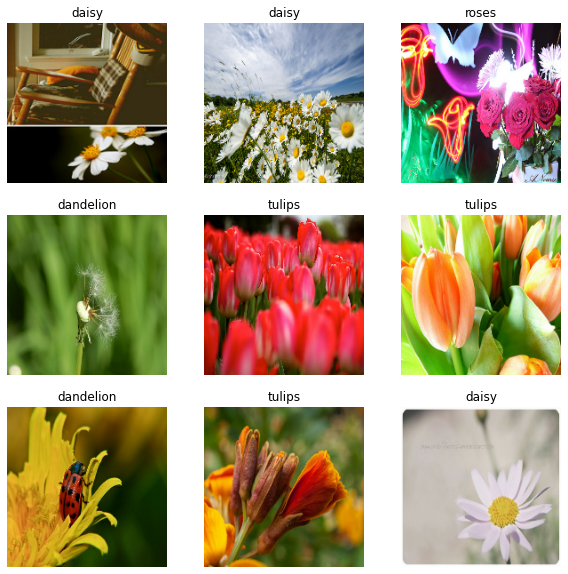

In [33]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### 继续训练模型

您现在已经手动构建了一个与由上面的 `keras.preprocessing` 创建的数据集类似的 `tf.data.Dataset`。您可以继续用它来训练模型。和之前一样，您将只训练几个周期以确保较短的运行时间。

In [34]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 26s 272ms/step - loss: 0.7345 - accuracy: 0.7316 - val_loss: 0.8404 - val_accuracy: 0.6935
Epoch 2/3
92/92 [==============================] - 25s 275ms/step - loss: 0.5590 - accuracy: 0.7885 - val_loss: 0.8347 - val_accuracy: 0.6935
Epoch 3/3
92/92 [==============================] - 24s 263ms/step - loss: 0.3829 - accuracy: 0.8706 - val_loss: 0.8415 - val_accuracy: 0.6853


## 使用 TensorFlow Datasets

到目前为止，本教程的重点是从磁盘加载数据。此外，您还可以通过在 [TensorFlow Datasets](https://tensorflow.google.cn/datasets/catalog/overview) 上探索易于下载的大型数据集[目录](https://tensorflow.google.cn/datasets)来查找要使用的数据集。

由于您之前已经从磁盘加载了花卉数据集，接下来看看如何使用 TensorFlow Datasets 导入它。

使用 TensorFlow Datasets 下载花卉[数据集](https://tensorflow.google.cn/datasets/catalog/tf_flowers)：

In [35]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\hsuhau\tensorflow_datasets\tf_flowers\3.0.1.incomplete1IT126\tf_flowers-train.tfrecord*...:…

Dataset tf_flowers downloaded and prepared to C:\Users\hsuhau\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


花卉数据集有五个类：

In [36]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


从数据集中检索图像：

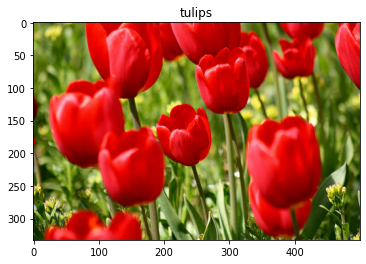

In [37]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

和以前一样，请记得对训练集、验证集和测试集进行批处理、打乱顺序和配置以提高性能。

In [38]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

您可以通过访问[数据增强](../images/data_augmentation.ipynb)教程找到使用花卉数据集和 TensorFlow Datasets 的完整示例。

## 后续步骤

本教程展示了从磁盘加载图像的两种方式。首先，您学习了如何使用 Keras 预处理层和效用函数加载和预处理图像数据集。接下来，您学习了如何使用 `tf.data` 从头开始编写输入流水线。最后，您学习了如何从 TensorFlow Datasets 下载数据集。

后续步骤：

- 您可以学习[如何添加数据增强](https://tensorflow.google.cn/tutorials/images/data_augmentation)。
- 要详细了解 `tf.data`，您可以访问 [tf.data：构建 TensorFlow 输入流水线](https://tensorflow.google.cn/guide/data)指南。